In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

!pip install string-kernels
from stringkernels.kernels import string_kernel
from stringkernels.kernels import polynomial_string_kernel

from collections import Counter

from tqdm.notebook import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/kaggle/input/kaggle-competition-2/train_results.csv
/kaggle/input/kaggle-competition-2/train_data.csv
/kaggle/input/kaggle-competition-2/test_data.csv


In [3]:
train_data = pd.read_csv("../input/kaggle-competition-2/train_data.csv").drop(columns=["id"])
train_labels = pd.read_csv("../input/kaggle-competition-2/train_results.csv").drop(columns=["id"])
test_data = pd.read_csv("../input/kaggle-competition-2/test_data.csv").drop(columns=["id"])

In [4]:
print(len(train_data), len(train_labels))
keep_index_train = train_data.drop_duplicates().index.tolist()
train_data = train_data.iloc[keep_index_train].reset_index()
train_labels = train_labels.iloc[keep_index_train].reset_index()
print(len(train_data), len(train_labels))
train_data = train_data.sample(len(train_data)//100, random_state=42)
train_labels = train_labels.iloc[train_data.index.tolist()].reset_index()
train_data.reset_index()
print(len(train_data), len(train_labels))

1040323 1040323
1030487 1030487
10304 10304


In [5]:
def transform_label_to_numeric(label) :
    if label == "negative" :
        return 0
    elif label == "neutral" :
        return 1
    return 2

In [6]:
train_labels["target"] = train_labels["target"].apply(lambda x : transform_label_to_numeric(x))
train_labels

,level_0,index,target
0,425560,428214,2
1,5007,5010,2
2,796677,803414,2
3,564269,568339,0
4,583483,587752,0
...,...,...,...
10299,67868,68032,0
10300,852294,859747,0
10301,461537,464533,0
10302,30805,30841,0


In [7]:
neg_percentage = len(np.where(train_labels["target"] == 0)[0])/len(train_labels["target"])*100
neut_percentage = len(np.where(train_labels["target"] == 1)[0])/len(train_labels["target"])*100
pos_percentage = len(np.where(train_labels["target"] == 2)[0])/len(train_labels["target"])*100
print(pos_percentage)
print(neg_percentage)
print(neut_percentage)

50.184394409937894
49.80590062111801
0.009704968944099378


In [8]:
def normalisation(message):
    message = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', message)
    message = re.sub('@[^\s]+','USER', message)
    message = message.lower()
    message = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', message) 
    message = re.sub(' +',' ', message)
    message = re.sub(r'([?ahijquvwxy])\1+', lambda g:f'{g.group(0)[1]}', message)
    message = re.sub(r'([?bcdefgklmnoprstz])\1{2,}', lambda g:f'{g.group(0)[1]}', message)
    return message.strip()

stopWords = stopwords.words('english')
def erase_stopwords(message) :
    return ' '.join([mot for mot in message.split() if mot not in (stopWords)])

stemmer = SnowballStemmer('english')
def stemmisation(message) :
    return ' '.join([stemmer.stem(mot) for mot in message.split()])

lemmatizer = WordNetLemmatizer()
def lemmatisation(message) :
    return ' '.join([lemmatizer.lemmatize(mot) for mot in message.split(' ')])

def pre_processing(message, norm=True, sw=True, lemm=True, stemm=True) :
    if norm : 
        message = normalisation(message)
    if sw :
        message = erase_stopwords(message)
    if lemm :
        message = lemmatisation(message)
    if stemm :
        message = stemmisation(message)
    return message

# 1) Noramalisation

In [9]:
train_data1 = train_data.copy()
test_data1 = test_data.copy()

In [10]:
train_data1["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))
test_data1["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False, stemm=False))

train_data1

,index,text
425560,428214,at a hotel w my fam super awsome the view is g...
5007,5010,user this is like reading a balance sheet all ...
796677,803414,today is the last day
564269,568339,gah election nights are like crack for me why ...
583483,587752,its fa rezing ihy winter
...,...,...
67868,68032,mental note 2 self do not let dog eat left ovr...
852294,859747,user i have the coupons but they expired i thi...
461537,464533,user she had cancer
30805,30841,just finished top gear we are off to a great s...


In [11]:
counter1 = Counter()
for i in train_data1["text"] :
    counter1.update(i.split(" "))
print(len(counter1))

vocab1 = list(counter1.keys())

t_data1, v_data1, t_labels1, v_labels1 = train_test_split(train_data1, train_labels, test_size=0.2, random_state=42)

13114


In [16]:
class SVM :
    
    def __init__(self, counter, max_features, kernel=string_kernel()) :
        self.model = SVC(kernel=kernel, random_state=42)
        self.max_features = max_features
        self.vocab = [i[0] for i in counter.most_common(max_features)]
        self.count = CountVectorizer(vocabulary=self.vocab)
        self.transform = TfidfTransformer()
        
    def encode_BOF(self, data, fit) :
        # Encode text to BOF with our extract vocabulary
        if fit :
            bow = self.count.fit_transform(data["text"])
            bow = self.transform.fit_transform(bow)
        else :
            bow = self.count.transform(data["text"])
            bow = self.transform.transform(bow)
        return bow.toarray()
    
    def train(self, train_data, train_labels) :
        self.classes = train_labels["target"].unique()
        # Train(fit) on batch of size bs
        bow = self.encode_BOF(train_data, True)
        self.model.fit(bow, train_labels["target"])
            
    def predict(self, test_data, bs=10000) :
        # Test on batch of size bs (if test_data is too big to be encode at once)
        preds = []
        with np.errstate(divide='ignore'):
            for i in tqdm(range(0, len(test_data), bs)) :
                bow = self.encode_BOF(test_data.iloc[i:i+bs], False)
                preds += list(self.model.predict(bow))
                del bow
        return preds

In [44]:
accuracy1 = []
nb_features1 = list(range(250, 5250, 250)) + list(range(7500, 12500, 2500)) + [len(counter1)]
for i in tqdm(nb_features1) :
    model = SVM(counter1, i)
    model.train(t_data1, t_labels1)
    preds = model.predict(v_data1)
    accuracy1.append(accuracy_score(v_labels1["target"], preds))

  0%|          | 0/23 [00:00<?, ?it/s]

Max =  0.6773410965550704
Max atteint pour  250  features


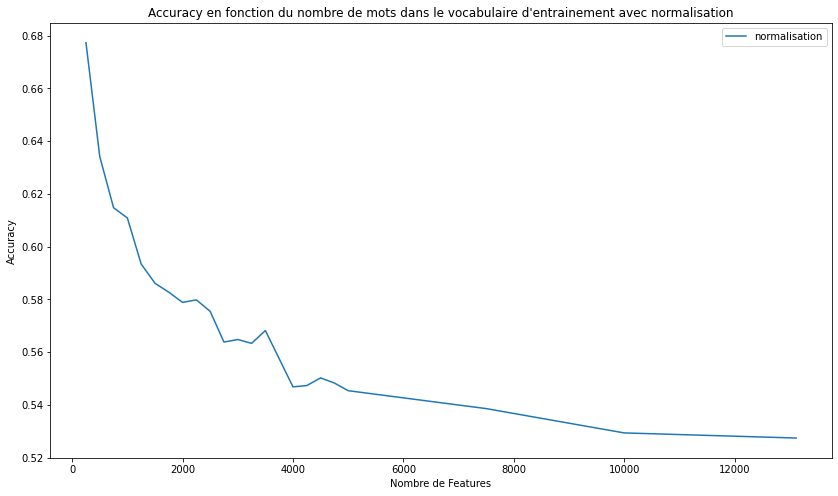

In [45]:
print("Max = ", max(np.array(accuracy1)))
print("Max atteint pour ", nb_features1[np.argmax(np.array(accuracy1))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features1, accuracy1, label="normalisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation")
plt.legend()
plt.show()

# 2) Normalisation + Lemmisation

In [46]:
train_data2 = train_data.copy()
test_data2 = test_data.copy()

In [47]:
train_data2["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, stemm=False))
test_data2["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, stemm=False))

train_data2

,index,text
425560,428214,at a hotel w my fam super awsome the view is g...
5007,5010,user this is like reading a balance sheet all ...
796677,803414,today is the last day
564269,568339,gah election night are like crack for me why d...
583483,587752,it fa rezing ihy winter
...,...,...
67868,68032,mental note 2 self do not let dog eat left ovr...
852294,859747,user i have the coupon but they expired i thin...
461537,464533,user she had cancer
30805,30841,just finished top gear we are off to a great s...


In [48]:
counter2 = Counter()
for i in train_data2["text"] :
    counter2.update(i.split(" "))
print(len(counter2))

vocab2 = list(counter2.keys())

t_data2, v_data2, t_labels2, v_labels2 = train_test_split(train_data2, train_labels, test_size=0.2, random_state=42)

13114


In [49]:
accuracy2 = []
nb_features2 = list(range(250, 1250, 250))
for i in tqdm(nb_features2) :
    model = SVM(counter2, i)
    model.train(t_data2, t_labels2)
    preds = model.predict(v_data2)
    accuracy2.append(accuracy_score(v_labels2["target"], preds))

  0%|          | 0/4 [00:00<?, ?it/s]

Max =  0.6666666666666666
Max atteint pour  250  features


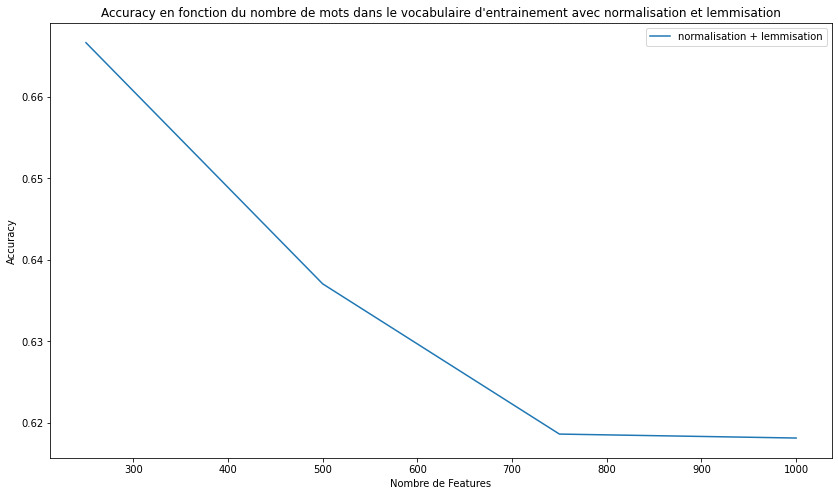

In [51]:
print("Max = ", max(np.array(accuracy2)))
print("Max atteint pour ", nb_features2[np.argmax(np.array(accuracy2))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features2, accuracy2, label="normalisation + lemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation et lemmisation")
plt.legend()
plt.show()

# 3) Normalisation + StopWords

In [52]:
train_data3 = train_data.copy()
test_data3 = test_data.copy()

In [53]:
train_data3["text"] = train_data["text"].apply(lambda m : pre_processing(m, lemm=False, stemm=False))
test_data3["text"] = test_data["text"].apply(lambda m : pre_processing(m, lemm=False, stemm=False))

train_data3

,index,text
425560,428214,hotel w fam super awsome view gr8 chilling rit...
5007,5010,user like reading balance sheet fun eh lol
796677,803414,today last day
564269,568339,gah election nights like crack night last exam...
583483,587752,fa rezing ihy winter
...,...,...
67868,68032,mental note 2 self let dog eat left ovr broccoli
852294,859747,user coupons expired think purchase anyway wat...
461537,464533,user cancer
30805,30841,finished top gear great season bad gonna 7 epi...


In [54]:
counter3 = Counter()
for i in train_data3["text"] :
    counter3.update(i.split(" "))
print(len(counter3))

vocab3 = list(counter3.keys())

t_data3, v_data3, t_labels3, v_labels3 = train_test_split(train_data3, train_labels, test_size=0.2, random_state=42)

12969


In [55]:
accuracy3 = []
nb_features3 = list(range(250, 1250, 250))
for i in tqdm(nb_features3) :
    model = SVM(counter3, i)
    model.train(t_data3, t_labels3)
    preds = model.predict(v_data3)
    accuracy3.append(accuracy_score(v_labels3["target"], preds))

  0%|          | 0/4 [00:00<?, ?it/s]

Max =  0.658418243571082
Max atteint pour  250  features


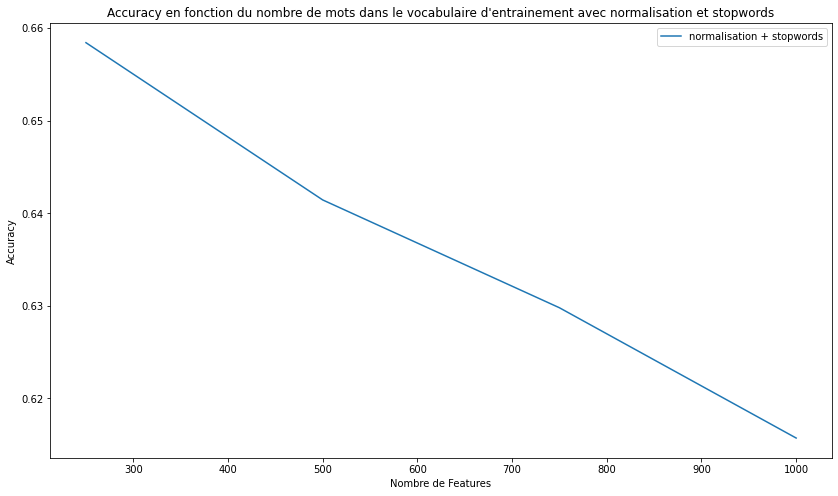

In [56]:
print("Max = ", max(np.array(accuracy3)))
print("Max atteint pour ", nb_features3[np.argmax(np.array(accuracy3))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features3, accuracy3, label="normalisation + stopwords")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation et stopwords")
plt.legend()
plt.show()

# 4) Normalisation + Stemmisation

In [57]:
train_data4 = train_data.copy()
test_data4 = test_data.copy()

In [58]:
train_data4["text"] = train_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False))
test_data4["text"] = test_data["text"].apply(lambda m : pre_processing(m, sw=False, lemm=False))

train_data4

,index,text
425560,428214,at a hotel w my fam super awsom the view is gr...
5007,5010,user this is like read a balanc sheet all fun ...
796677,803414,today is the last day
564269,568339,gah elect night are like crack for me whi do t...
583483,587752,it fa reze ihi winter
...,...,...
67868,68032,mental note 2 self do not let dog eat left ovr...
852294,859747,user i have the coupon but they expir i think ...
461537,464533,user she had cancer
30805,30841,just finish top gear we are off to a great sea...


In [59]:
counter4 = Counter()
for i in train_data4["text"] :
    counter4.update(i.split(" "))
print(len(counter4))

vocab4 = list(counter4.keys())

t_data4, v_data4, t_labels4, v_labels4 = train_test_split(train_data4, train_labels, test_size=0.2, random_state=42)

10474


In [60]:
accuracy4 = []
nb_features4 = list(range(250, 1250, 250))
for i in tqdm(nb_features4) :
    model = SVM(counter4, i)
    model.train(t_data4, t_labels4)
    preds = model.predict(v_data4)
    accuracy4.append(accuracy_score(v_labels4["target"], preds))

  0%|          | 0/4 [00:00<?, ?it/s]

Max =  0.6642406598738476
Max atteint pour  250  features


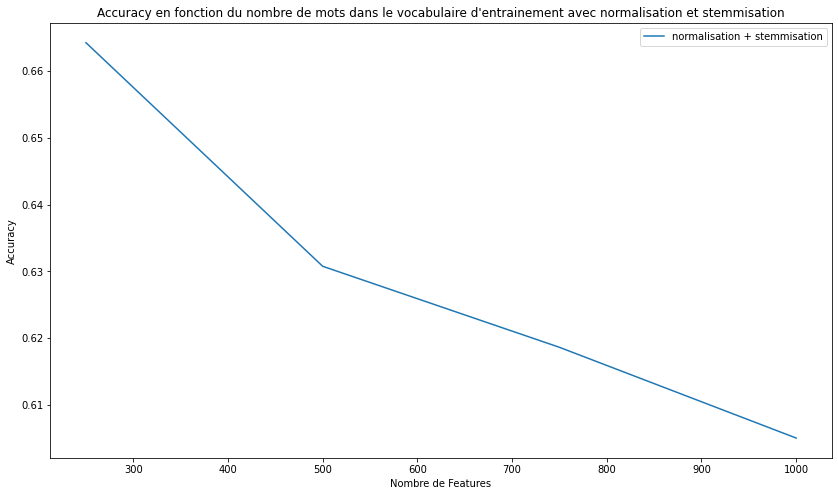

In [61]:
print("Max = ", max(np.array(accuracy4)))
print("Max atteint pour ", nb_features4[np.argmax(np.array(accuracy4))], " features")

plt.figure(figsize = [14, 8])
plt.plot(nb_features4, accuracy4, label="normalisation + stemmisation")
plt.xlabel("Nombre de Features")
plt.ylabel("Accuracy")
plt.title("Accuracy en fonction du nombre de mots dans le vocabulaire d'entrainement avec normalisation et stemmisation")
plt.legend()
plt.show()

In [17]:
model = SVM(counter1, 250)
model.train(t_data1, t_labels1)
preds = model.predict(test_data)
preds = [[i, preds[i]] for i in range(len(preds))]
df = pd.DataFrame(preds, columns = ["id", "target"])
df.to_csv("./predictions_svm.csv", index = False)

  0%|          | 0/57 [00:00<?, ?it/s]